In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import time
import h5py
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
DSPACK_HOME=os.environ.get("DSPACK_HOME")
if DSPACK_HOME not in sys.path:
    sys.path.append(DSPACK_HOME)

In [4]:
import scripts.image 
import scripts.fsystem
import scripts.statistics

In [5]:
workdir = "/reg/data/ana03/scratch/zhensu/Experiment/ICH/20201225/"
dnames = ["WT-1", "WT-2", "WT-3", "G150A-1", "G150A-2", "G150A-3", "G150T-1", "G150T-2", "G150T-3"]

In [6]:
zfilter = scripts.image.FilterTools()
mean_filter = zfilter.mean_filter

In [7]:
def cut_slice(data, mask, center, idx, half_depth=2):
    v = data * mask
    if idx == 0:
        image = np.sum(v[(center-half_depth):(center+half_depth+1),:,:],axis=0)
        masks = np.sum(mask[(center-half_depth):(center+half_depth+1),:,:],axis=0)
        index = np.where(masks>0)
        image[index] /= masks[index]
        image[masks<=0] = -1024
        return image
    if idx == 1:
        image = np.sum(v[:,(center-half_depth):(center+half_depth+1),:],axis=1)
        masks = np.sum(mask[:,(center-half_depth):(center+half_depth+1),:],axis=1)
        index = np.where(masks>0)
        image[index] /= masks[index]
        image[masks<=0] = -1024
        return image
    if idx == 2:
        image = np.sum(v[:,:,(center-half_depth):(center+half_depth+1)],axis=2)
        masks = np.sum(mask[:,:,(center-half_depth):(center+half_depth+1)],axis=2)
        index = np.where(masks>0)
        image[index] /= masks[index]
        image[masks<=0] = -1024
        return image

In [8]:
Vmin = {'G150A-1': [-1.5837136892290515, -3.3653499153339697, -2.4988260438265],
 'G150A-2': [-1.3085976556424059, -1.9441395690353866, -1.413119694407835],
 'G150A-3': [-1.3213963913834506, -3.3774080422108375, -2.5288549652067731],
 'G150T-1': [-1.252499273728664, -2.0422783730322829, -1.275232579196333],
 'G150T-2': [-2.0082480303734629, -3.3005483093697183, -2.1954999398702348],
 'G150T-3': [-2.8020105628911578, -4.0617032001808386, -2.9940249951647515],
 'WT-1': [-3.3971781954256599, -5.5333633083606006, -4.2284963359614265],
 'WT-2': [-1.2603902051742468, -2.7291167307734496, -2.3694521045805081],
 'WT-3': [-3.5749026932743067, -5.0271376013239939, -4.0240326066706436]}
Vmax = {'G150A-1': [1.8634379881319059, 2.5481483092320936, 1.5314349072800775],
 'G150A-2': [1.2179239573423215, 2.0655173792984849, 1.3002491767011688],
 'G150A-3': [1.7506255138303741, 2.5099189858109723, 1.7651150848639274],
 'G150T-1': [1.0765227737565475, 1.8526097852763597, 1.236134576643247],
 'G150T-2': [1.8965472490714963, 3.2021016547664227, 2.262069063046916],
 'G150T-3': [2.4454652729471102, 4.1958699252009302, 2.4847784751535631],
 'WT-1': [3.9014425533447992, 4.9940212421931136, 2.923434477008902],
 'WT-2': [1.4750139655477206, 2.2302708278543948, 1.4199920711013192],
 'WT-3': [3.1354703168739455, 4.8600660417996302, 3.2603364677379565]}

In [9]:
resolution_A = np.array([-1.4, -2.8, 1e9, 2.8, 1.4])
tick_symbol = np.array(["1.4", "2.8", "$O$", "2.8", "1.4"])
half_depth = 4 # box length 2*depth+1

## Qx direction

/reg/data/ana03/scratch/zhensu/Develop/psvolume/v3.0/psvolume/scripts/fsystem.py:44: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[keys].value


WT-1
WT-2
WT-3
G150A-1
G150A-2
G150A-3
G150T-1
G150T-2
G150T-3
dpi =  539


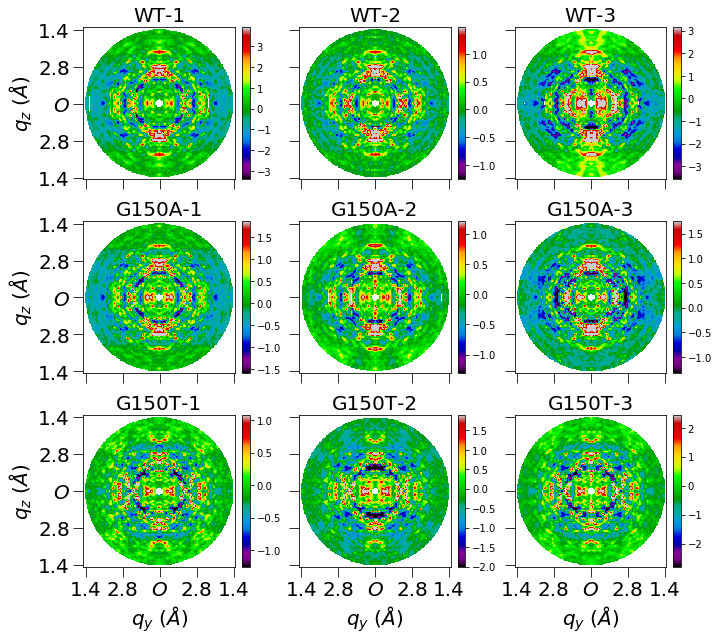

In [10]:
direction = "qx"

data_backup = {}
plt.figure(figsize=(10,9))
for idet, dname in enumerate(dnames):
    path_dsdata = "%s/data/%s/standard_clean_data_scale_profile_map1.dsdata_map3.dsdata"%(workdir,dname)
    path_volume = scripts.fsystem.H5manager.reader(path_dsdata,"merge_volume")
    with h5py.File(path_volume, "r") as f:
        oversample = f["oversample"][()]
        exp_sym_sub_xyz = f["volume_laue_sym_backg_sub_xyz"][()]
        voxel_length_invA = np.linalg.norm(f["Bmat_invA"][:,1]) * 1.0 / oversample
        max_voxel_radius = 1./1.4/voxel_length_invA

    if direction == "qx":
        cut_idx = 0
        xaxis = "$q_y$"
        yaxis = "$q_z$"
    elif direction == "qy":
        cut_idx = 1
        xaxis = "$q_x$"
        yaxis = "$q_z$"
    else:
        cut_idx = 2
        xaxis = "$q_x$"
        yaxis = "$q_y$"
    
    x = np.arange(361)-180
    x,y = np.meshgrid(x,x,indexing="ij")
    r = np.sqrt(x**2+y**2)
    exp_slice = cut_slice(exp_sym_sub_xyz, (exp_sym_sub_xyz>-100).astype(int), 180, cut_idx, half_depth=half_depth)
    exp_slice[r>max_voxel_radius] = -1024
    
    pattern = exp_slice.copy()
    mask = (pattern>-100).astype(int)
    pattern = zfilter.mean_filter(image=pattern,mask=mask,window=(3,3))
    pattern[mask==0]=-1024 
    masked_array = np.ma.masked_where(pattern == -1024, pattern)
    cmap = matplotlib.cm.nipy_spectral
    cmap.set_bad(color='white')
    
    vmin = Vmin[dname][cut_idx]
    vmax = Vmax[dname][cut_idx]
    
    print dname
    plt.subplot(3,3,1+idet)
    plt.imshow(masked_array.T, clim=(vmin, vmax),cmap=cmap)
    if idet in [6,7,8]:
        plt.xticks(1./resolution_A/voxel_length_invA+180, tick_symbol, fontsize=20)
        plt.xlabel("%s ($\AA$)"%xaxis, fontsize=20)
    else:
        plt.xticks(1./resolution_A/voxel_length_invA+180, [], fontsize=20)
    if idet in [0,3,6]:
        plt.yticks(1./resolution_A/voxel_length_invA+180, tick_symbol, fontsize=20)
        plt.ylabel("%s ($\AA$)"%yaxis, fontsize=20)
    else:
        plt.yticks(1./resolution_A/voxel_length_invA+180, [], fontsize=20)
    
    plt.xlim(-1/1.4/voxel_length_invA+180-4, 1/1.4/voxel_length_invA+180+3)
    plt.ylim(-1/1.4/voxel_length_invA+180-3, 1/1.4/voxel_length_invA+180+4)
    
    plt.tick_params('y', length=10, which='major')
    plt.tick_params('x', length=10, which='major')
    
    plt.title("%s"%dname, fontsize=20)
    plt.colorbar(fraction=0.046, pad=0.04)
    data_backup[dname] = masked_array.data

fig = plt.gcf()
max_fit_dpi = min(int(np.sqrt(25.*1024**2/np.prod(fig.get_size_inches()))),600)
print "dpi = ", max_fit_dpi
plt.tight_layout()
plt.savefig("./600dpi/Fig_S08_Diffraction_Volume_No_PCA_Qx.jpg",dpi=600,bbox_inches='tight',pad_inches=0,transparent=True)
plt.savefig("./fitgdoc/Fig_S08_Diffraction_Volume_No_PCA_Qx.jpg",dpi=max_fit_dpi,bbox_inches='tight',pad_inches=0,transparent=True)
plt.show()